In [10]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import sys
from keras.models import load_model
from netCDF4 import Dataset
import os
from tools import Ps_to_sea_level, load_ERA_variables, load_WProf_variables

In [11]:
## Load radar / radiometer (WProf) measurements
fwp = sorted(glob.glob('/ltedata/ICEGENESIS_2021/WProf/NetCDF/LV2/Y2021/M01/D27/*.nc'))
(t, Ts, Ps, RHs, TB, LWPrpg) = load_WProf_variables(fwp)

In [12]:
## Load ERA5 variables, if available
erapath = '/home/billault/Documents/LWPretrieval/mise_au_propre/ICEGENESIS_Jan_ERA5_for_LWP.nc'
(LWPera, PWVera) = load_ERA_variables(erapath, t)

In [13]:
## Prepare the other variables to be used in retrieval (cf paper)
## Surface variables ("SURF" category)
Ps = Ps_to_sea_level(np.array(Ps), np.array(Ts), 1050)
Ts = Ts-273.15
Ps = Ps*1e2

## Geographical information ("GEO") category
alt = np.zeros(len(TB))+1050.
lat = np.zeros(len(TB))+47.
lon = np.zeros(len(TB))+6.9

## Time of year (part of "GEO" category)
daynum = []
for tt in t:
    dt = datetime.datetime.utcfromtimestamp(tt)
    yr = dt.year
    daynum.append((dt-datetime.datetime(yr,1,1,0)).days+1+(dt-datetime.datetime(yr,1,1,0)).seconds/(24*3600))
date = np.array(daynum)


In [14]:
## Define which sets of parameters should be used for retrieval (cf paper)
GEO = True
ERA = True
SURF = True

In [15]:
## Function which defines the corresponding dataframe and runs the retrieval model
## Note: this uses some of the pre-defined fields!!
def predict(lwp_or_pwv):
    if (not GEO) and ERA and SURF:
        df = pd.DataFrame({'Ts':Ts,'Ps':Ps,'RHs':RHs, 'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['LWPera','PWVera','Ps','RHs','TB','Ts','TB2'])
        mean = np.load('parameters/ERA_noGeo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/ERA_noGeo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/ERA_noGeo_Surf/%smodel_ERA_noGeo_Surf_TB12'%lwp_or_pwv)
    if GEO and ERA and SURF:
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date, 'Ts':Ts,'Ps':Ps,'RHs':RHs, 'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['LWPera','PWVera', 'Ps', 'RHs', 'TB', 'Ts', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/ERA_Geo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/ERA_Geo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/ERA_Geo_Surf/%smodel_ERA_Geo_Surf_TB12'%lwp_or_pwv)
    if GEO and ERA and (not SURF):
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date,  'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['LWPera', 'PWVera', 'TB', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/ERA_Geo_noSurf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/ERA_Geo_noSurf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/ERA_Geo_noSurf/%smodel_ERA_Geo_noSurf_TB12'%lwp_or_pwv)

    if (not GEO) and (not ERA) and SURF:
        df = pd.DataFrame({'Ts':Ts,'Ps':Ps,'RHs':RHs, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['Ps','RHs','TB','Ts','TB2'])
        mean = np.load('parameters/noERA_noGeo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/noERA_noGeo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/noERA_noGeo_Surf/%smodel_noERA_noGeo_Surf_TB12'%lwp_or_pwv)
    if GEO and (not ERA) and SURF:
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date, 'Ts':Ts,'Ps':Ps,'RHs':RHs, 'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['Ps', 'RHs', 'TB', 'Ts', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/noERA_Geo_Surf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/noERA_Geo_Surf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/noERA_Geo_Surf/%smodel_noERA_Geo_Surf_TB12'%lwp_or_pwv)
    if GEO and (not ERA) and (not SURF):
        df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date,'TB':TB, 'TB2': TB**2})
        df = df.reindex(columns=['TB', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
        mean = np.load('parameters/noERA_Geo_noSurf/mean_for_%s.npy'%lwp_or_pwv)
        std = np.load('parameters/noERA_Geo_noSurf/std_for_%s.npy'%lwp_or_pwv)
        model = load_model('parameters/noERA_Geo_noSurf/%smodel_noERA_Geo_noSurf_TB12'%lwp_or_pwv)


    # Normalize the input features
    npdf = (df.to_numpy()-mean)/std
    # Run the prediction
    pred = model.predict(npdf)
    # This ensures that there are no doubles (safety)
    tpred,inds = np.unique(t,return_index=True)
    pred = pred[inds]
    
    return (tpred,pred)

In [16]:
if (not GEO) and ERA and SURF:
    df = pd.DataFrame({'Ts':Ts,'Ps':Ps,'RHs':RHs, 'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
    df = df.reindex(columns=['LWPera','PWVera','Ps','RHs','TB','Ts','TB2'])
    mean = np.load('parameters/ERA_noGeo_Surf/mean_for_LWP.npy')
    std = np.load('parameters/ERA_noGeo_Surf/std_for_LWP.npy')
    model = load_model('parameters/ERA_noGeo_Surf/LWPmodel_ERA_noGeo_Surf_TB12')
if GEO and ERA and SURF:
    df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date, 'Ts':Ts,'Ps':Ps,'RHs':RHs, 'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
    df = df.reindex(columns=['LWPera','PWVera', 'Ps', 'RHs', 'TB', 'Ts', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
    mean = np.load('parameters/ERA_Geo_Surf/mean_for_LWP.npy')
    std = np.load('parameters/ERA_Geo_Surf/std_for_LWP.npy')
    model = load_model('parameters/ERA_Geo_Surf/LWPmodel_ERA_Geo_Surf_TB12')
if GEO and ERA and (not SURF):
    df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date,  'LWPera':LWPera, 'PWVera':PWVera, 'TB':TB, 'TB2': TB**2})
    df = df.reindex(columns=['LWPera', 'PWVera', 'TB', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
    mean = np.load('parameters/ERA_Geo_noSurf/mean_for_LWP.npy')
    std = np.load('parameters/ERA_Geo_noSurf/std_for_LWP.npy')
    model = load_model('parameters/ERA_Geo_noSurf/LWPmodel_ERA_Geo_noSurf_TB12')
if (not GEO) and (not ERA) and SURF:
    df = pd.DataFrame({'Ts':Ts,'Ps':Ps,'RHs':RHs, 'TB':TB, 'TB2': TB**2})
    df = df.reindex(columns=['Ps','RHs','TB','Ts','TB2'])
    mean = np.load('parameters/noERA_noGeo_Surf/mean_for_LWP.npy')
    std = np.load('parameters/noERA_noGeo_Surf/std_for_LWP.npy')
    model = load_model('noERA_noGeo_Surf/LWPmodel_noERA_noGeo_Surf_TB12')
if GEO and (not ERA) and SURF:
    df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date, 'Ts':Ts,'Ps':Ps,'RHs':RHs, 'TB':TB, 'TB2': TB**2})
    df = df.reindex(columns=['Ps', 'RHs', 'TB', 'Ts', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
    mean = np.load('parameters/noERA_Geo_Surf/mean_for_LWP.npy')
    std = np.load('parameters/noERA_Geo_Surf/std_for_LWP.npy')
    model = load_model('parameters/noERA_Geo_Surf/LWPmodel_noERA_Geo_Surf_TB12')
if GEO and (not ERA) and (not SURF):
    df = pd.DataFrame({'altitude':alt, 'latitude':lat, 'longitude':lon, 'date': date,'TB':TB, 'TB2': TB**2})
    df = df.reindex(columns=['TB', 'altitude', 'date', 'latitude', 'longitude', 'TB2'])
    mean = np.load('parameters/noERA_Geo_noSurf/mean_for_LWP.npy')
    std = np.load('parameters/noERA_Geo_noSurf/std_for_LWP.npy')
    model = load_model('parameters/noERA_Geo_noSurf/LWPmodel_noERA_Geo_noSurf_TB12')
    

467/467 [==============================] - 0s 802us/step


Text(0, 0.5, 'LWP [g m$^{-2}$]')

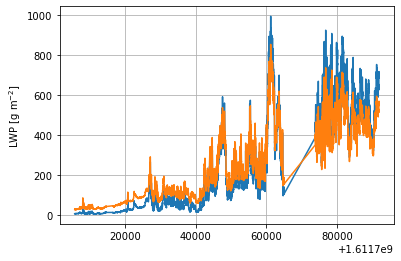

In [19]:
tpred,LWPpred = predict('LWP')

plt.plot(tpred,LWPpred)
plt.plot(t,LWPrpg)
plt.grid()
plt.ylabel('LWP [g m$^{-2}$]')


467/467 [==============================] - 0s 878us/step


Text(0, 0.5, 'PWV [kg m$^{-2}$]')

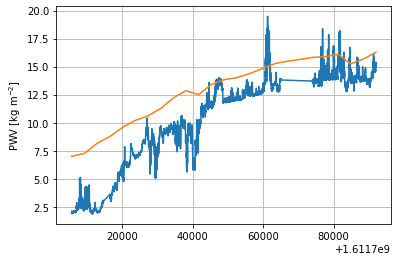

In [20]:
tpred,PWVpred = predict('PWV')

plt.plot(tpred,PWVpred)
plt.plot(t,PWVera)
plt.grid()
plt.ylabel('PWV [kg m$^{-2}$]')